# Curvilinear Interpolation using `HARK`'s `CurvilinearInterp` class


This notebook uses examples from `scipy` documentation to demonstrate `HARK`'s `Warped2DInterp` class.


In [1]:
from __future__ import annotations

from time import time

import matplotlib.pyplot as plt
import numpy as np
from HARK.interpolation import Curvilinear2DInterp

from multinterp.curvilinear import Warped2DInterp

Suppose we have a collection of values for an unknown function along with their respective coordinate points. For illustration, assume the values come from the following function:


In [2]:
def function_1(x, y):
    return x * (1 - x) * np.cos(4 * np.pi * x) * np.sin(4 * np.pi * y**2) ** 2

The points are randomly scattered in the unit square and therefore have no regular structure.


In [3]:
rng = np.random.default_rng(0)
warp_factor = 0.01
x_list = np.linspace(0, 1, 20)
y_list = np.linspace(0, 1, 20)
x_temp, y_temp = np.meshgrid(x_list, y_list, indexing="ij")
rand_x = x_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
rand_y = y_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
values = function_1(rand_x, rand_y)

Now suppose we would like to interpolate this function on a rectilinear grid, which is known as "regridding".


In [4]:
grid_x, grid_y = np.meshgrid(
    np.linspace(0, 1, 100), np.linspace(0, 1, 100), indexing="ij"
)

To do this, we use `HARK`'s `Warped2DInterp` class. The class takes the following arguments:

- `values`: an ND-array of values for the function at the points
- `grids`: a list of ND-arrays of coordinates for the points
- `method`: the interpolation method to use, with options WarpedInterp, "linear", "cubic" (for 2D only), and "rbf". The default is `'linear'`.


In [5]:
warped_interp = Warped2DInterp(values, (rand_x, rand_y), backend="numba")
warped_interp.warmup()

Once we create the interpolator objects, we can use them using the `__call__` method which takes as many arguments as there are dimensions.


In [6]:
start = time()
warped_grid = warped_interp(grid_x, grid_y)
print(f"Warped interpolation took {time() - start:.5f} seconds")

Warped interpolation took 0.00253 seconds


In [7]:
curvilinear_interp = Curvilinear2DInterp(values, rand_x, rand_y)
start = time()
curvilinear_grid = curvilinear_interp(grid_x, grid_y)
print(f"Curvilinear interpolation took {time() - start:.5f} seconds")

Curvilinear interpolation took 0.01309 seconds


Now we can compare the results of the interpolation with the original function. Below we plot the original function and the sample points that are known.


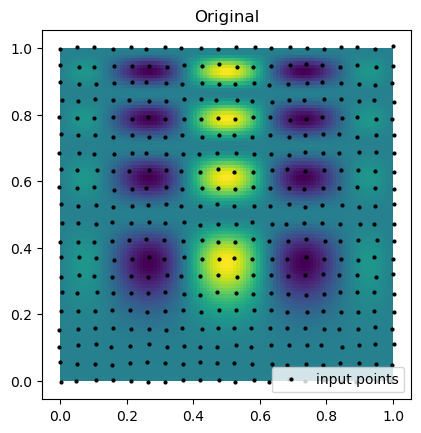

In [8]:
plt.imshow(function_1(grid_x, grid_y).T, extent=(0, 1, 0, 1), origin="lower")
plt.plot(rand_x.flat, rand_y.flat, "ok", ms=2, label="input points")
plt.title("Original")
plt.legend(loc="lower right")

Then, we can look at the result for each method of interpolation and compare it to the original function.


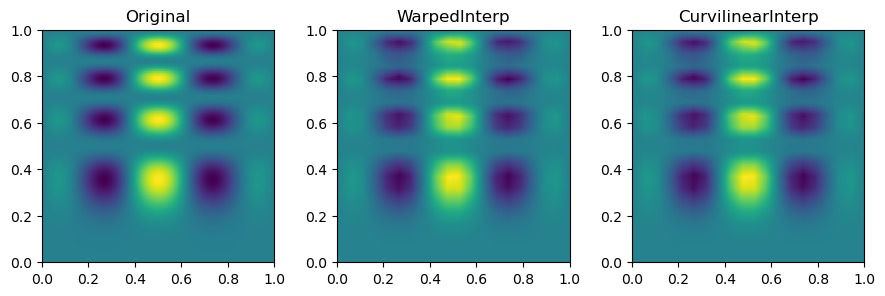

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(9, 6))
titles = ["Original", "WarpedInterp", "CurvilinearInterp"]
grids = [function_1(grid_x, grid_y), warped_grid, curvilinear_grid]

for ax, title, grid in zip(axs.flat, titles, grids):
    im = ax.imshow(grid.T, extent=(0, 1, 0, 1), origin="lower")
    ax.set_title(title)

plt.tight_layout()
plt.show()

## Another Example


In [10]:
def function_2(x, y):
    return np.hypot(x, y)

In [11]:
rng = np.random.default_rng(0)
warp_factor = 0.05
x_list = np.linspace(-0.5, 0.5, 10)
y_list = np.linspace(-0.5, 0.5, 10)
x_temp, y_temp = np.meshgrid(x_list, y_list, indexing="ij")
rand_x = x_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
rand_y = y_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
values = function_2(rand_x, rand_y)

In [12]:
grid_x, grid_y = np.meshgrid(
    np.linspace(-0.5, 0.5, 100), np.linspace(-0.5, 0.5, 100), indexing="ij"
)

In [13]:
warped_interp = Warped2DInterp(values, (rand_x, rand_y), backend="numba")

start = time()
warped_grid = warped_interp(grid_x, grid_y)
print(f"Warped interpolation took {time() - start:.5f} seconds")

Warped interpolation took 0.00100 seconds


In [14]:
curvilinear_interp = Curvilinear2DInterp(values, rand_x, rand_y)
start = time()
curvilinear_grid = curvilinear_interp(grid_x, grid_y)
print(f"Curvilinear interpolation took {time() - start:.5f} seconds")

Curvilinear interpolation took 0.00652 seconds


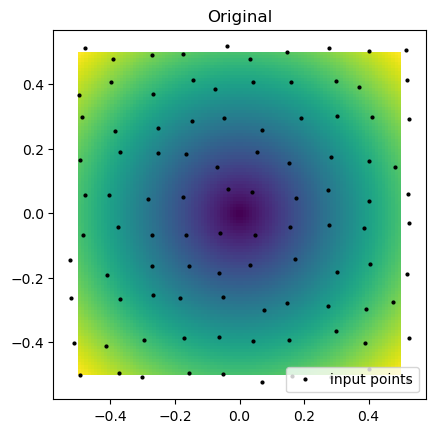

In [15]:
plt.imshow(function_2(grid_x, grid_y), extent=(-0.5, 0.5, -0.5, 0.5), origin="lower")
plt.plot(rand_x.flat, rand_y.flat, "ok", ms=2, label="input points")
plt.title("Original")
plt.legend(loc="lower right")

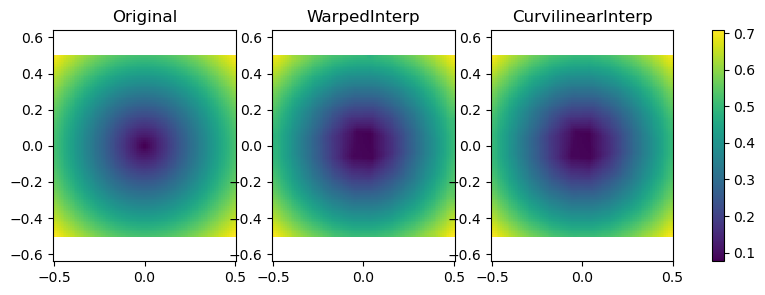

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
titles = ["Original", "WarpedInterp", "CurvilinearInterp"]
grids = [function_2(grid_x, grid_y), warped_grid, curvilinear_grid]

for _i, (ax, title, grid) in enumerate(zip(axs.flat, titles, grids)):
    im = ax.pcolormesh(grid_x, grid_y, grid, shading="auto")
    ax.set_title(title)

cbar = fig.colorbar(im, ax=axs)
for ax in axs.flat:
    ax.axis("equal")

plt.show()

# Unstructured Interpolators with Curvilinear Grids


In [17]:
def function_3(u, v):
    return u * np.cos(u * v) + v * np.sin(u * v)

In [18]:
rng = np.random.default_rng(0)
warp_factor = 0.1
x_list = np.linspace(0, 3, 10)
y_list = np.linspace(0, 3, 10)
x_temp, y_temp = np.meshgrid(x_list, y_list, indexing="ij")
rand_x = x_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
rand_y = y_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
values = function_3(rand_x, rand_y)

In [19]:
grid_x, grid_y = np.meshgrid(
    np.linspace(0, 3, 100), np.linspace(0, 3, 100), indexing="ij"
)

In [20]:
warped_interp = Warped2DInterp(values, (rand_x, rand_y), backend="numba")

In [21]:
start = time()
warped_grid = warped_interp(grid_x, grid_y)
print(f"Warped interpolation took {time() - start:.5f} seconds")

Warped interpolation took 0.00100 seconds


In [22]:
curvilinear_interp = Curvilinear2DInterp(values, rand_x, rand_y)
start = time()
curvilinear_grid = curvilinear_interp(grid_x, grid_y)
print(f"Curvilinear interpolation took {time() - start:.5f} seconds")

Curvilinear interpolation took 0.00704 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


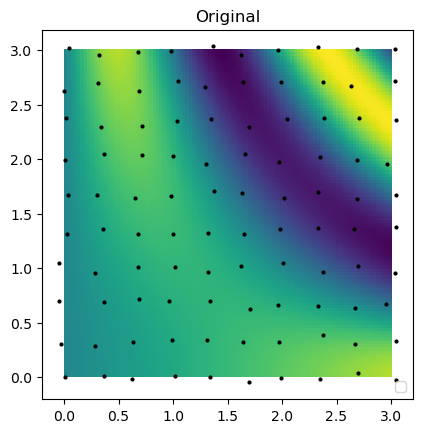

In [23]:
plt.imshow(function_3(grid_x, grid_y).T, extent=(0, 3, 0, 3), origin="lower")
plt.plot(rand_x.flat, rand_y.flat, "ok", ms=2)
plt.title("Original")
plt.legend(loc="lower right")

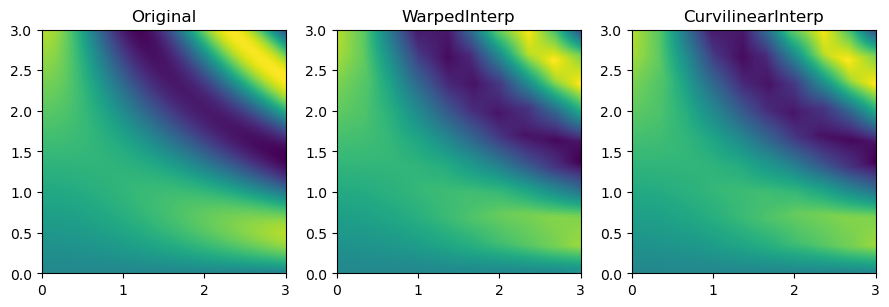

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
titles = ["Original", "WarpedInterp", "CurvilinearInterp"]
grids = [function_3(grid_x, grid_y), warped_grid, curvilinear_grid]

for ax, title, grid in zip(axs.flat, titles, grids):
    im = ax.imshow(grid, extent=(0, 3, 0, 3), origin="lower")
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [25]:
def function_4(x, y):
    return 3.0 * x**2.0 + x * y + 4.0 * y**2.0

In [26]:
rng = np.random.default_rng(0)
warp_factor = 0.2
x_list = np.linspace(0, 5, 10)
y_list = np.linspace(0, 5, 10)
x_temp, y_temp = np.meshgrid(x_list, y_list, indexing="ij")
rand_x = x_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
rand_y = y_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
values = function_4(rand_x, rand_y)

In [27]:
grid_x, grid_y = np.meshgrid(
    np.linspace(0, 5, 100), np.linspace(0, 5, 100), indexing="ij"
)

In [28]:
warped_interp = Warped2DInterp(values, (rand_x, rand_y), backend="numba")

In [29]:
start = time()
warped_grid = warped_interp(grid_x, grid_y)
print(f"Warped interpolation took {time() - start:.5f} seconds")

Warped interpolation took 0.00100 seconds


In [30]:
curvilinear_interp = Curvilinear2DInterp(values, rand_x, rand_y)
start = time()
curvilinear_grid = curvilinear_interp(grid_x, grid_y)
print(f"Curvilinear interpolation took {time() - start:.5f} seconds")

Curvilinear interpolation took 0.00854 seconds


Text(0.5, 1.0, 'Original')

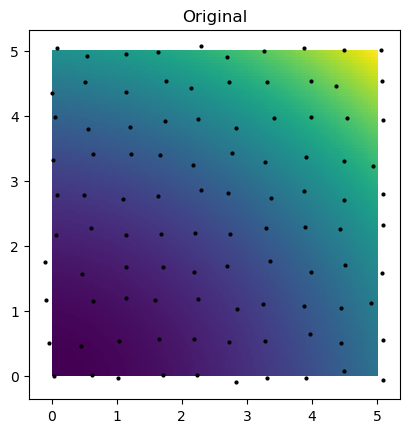

In [31]:
plt.imshow(function_4(grid_x, grid_y).T, extent=(0, 5, 0, 5), origin="lower")
plt.plot(rand_x, rand_y, "ok", ms=2)
plt.title("Original")

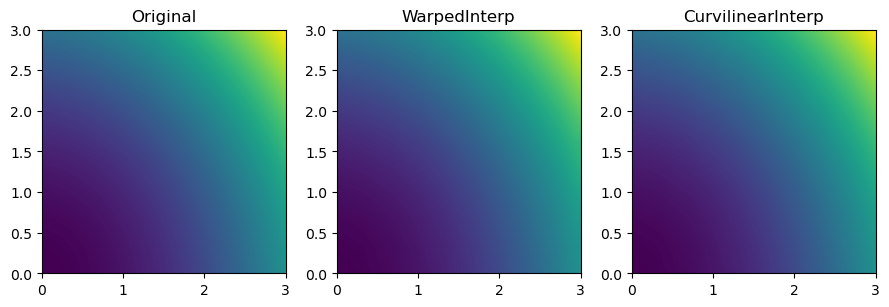

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
titles = ["Original", "WarpedInterp", "CurvilinearInterp"]
grids = [function_4(grid_x, grid_y), warped_grid, curvilinear_grid]

for ax, title, grid in zip(axs.flat, titles, grids):
    im = ax.imshow(grid, extent=(0, 3, 0, 3), origin="lower")
    ax.set_title(title)

plt.tight_layout()
plt.show()

# More complex functions


In [33]:
def function_5(*args):
    return np.maximum(
        0.0,
        1.0
        - np.exp(0.5 - np.prod(np.asarray(args) + 0.2, axis=0) ** (1.0 / len(args))),
    )

In [34]:
rng = np.random.default_rng(0)
warp_factor = 0.05
x_list = np.linspace(0, 1, 25)
y_list = np.linspace(0, 1, 25)
x_temp, y_temp = np.meshgrid(x_list, y_list, indexing="ij")
rand_x = x_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
rand_y = y_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
values = function_5(rand_x, rand_y)

In [35]:
grid_x, grid_y = np.meshgrid(
    np.linspace(0, 1, 100), np.linspace(0, 1, 100), indexing="ij"
)

In [36]:
warped_interp = Warped2DInterp(values, (rand_x, rand_y), backend="numba")

In [37]:
start = time()
warped_grid = warped_interp(grid_x, grid_y)
print(f"Warped interpolation took {time() - start:.5f} seconds")

Warped interpolation took 0.00100 seconds


In [38]:
curvilinear_interp = Curvilinear2DInterp(values, rand_x, rand_y)
start = time()
curvilinear_grid = curvilinear_interp(grid_x, grid_y)
print(f"Curvilinear interpolation took {time() - start:.5f} seconds")

Curvilinear interpolation took 0.02109 seconds


c:\Users\alujan\micromamba\envs\multinterp-dev\Lib\site-packages\HARK\interpolation.py:4243: RuntimeWarning: invalid value encountered in sqrt
  alpha = (-eta + polarity * np.sqrt(eta**2.0 - 4.0 * zeta * theta)) / (


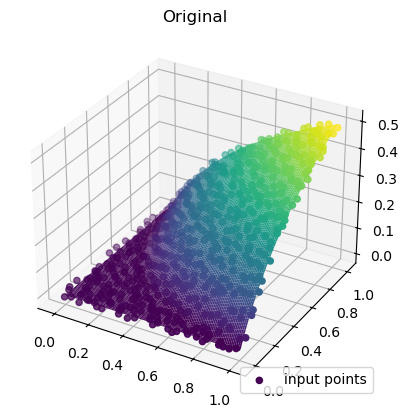

In [39]:
ax = plt.axes(projection="3d")
ax.plot_surface(
    grid_x,
    grid_y,
    function_5(grid_x, grid_y),
    rstride=1,
    cstride=1,
    cmap="viridis",
    edgecolor="none",
)
ax.scatter(rand_x, rand_y, values, c=values, cmap="viridis", label="input points")
plt.title("Original")
plt.legend(loc="lower right")

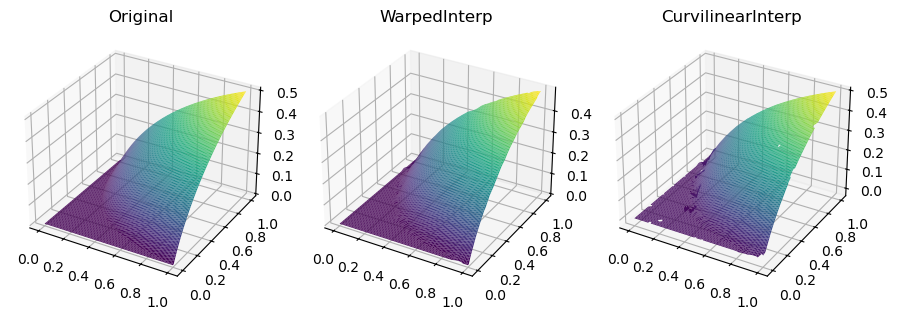

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), subplot_kw={"projection": "3d"})
titles = ["Original", "WarpedInterp", "CurvilinearInterp"]
grids = [function_5(grid_x, grid_y), warped_grid, curvilinear_grid]

for ax, title, grid in zip(axs.flat, titles, grids):
    im = ax.plot_surface(
        grid_x, grid_y, grid, rstride=1, cstride=1, cmap="viridis", edgecolor="none"
    )
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [41]:
def function_6(x, y):
    return 1 / (np.abs(0.5 - x**4 - y**4) + 0.1)

In [42]:
rng = np.random.default_rng(0)
warp_factor = 0.05
x_list = np.linspace(0, 1, 25)
y_list = np.linspace(0, 1, 25)
x_temp, y_temp = np.meshgrid(x_list, y_list, indexing="ij")
rand_x = x_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
rand_y = y_temp + warp_factor * (rng.random((x_list.size, y_list.size)) - 0.5)
values = function_6(rand_x, rand_y)

In [43]:
grid_x, grid_y = np.meshgrid(
    np.linspace(0, 1, 100), np.linspace(0, 1, 100), indexing="ij"
)

In [44]:
warped_interp = Warped2DInterp(values, (rand_x, rand_y), backend="numba")

In [45]:
start = time()
warped_grid = warped_interp(grid_x, grid_y)
print(f"Warped interpolation took {time() - start:.5f} seconds")

Warped interpolation took 0.00202 seconds


In [46]:
curvilinear_interp = Curvilinear2DInterp(values, rand_x, rand_y)
start = time()
curvilinear_grid = curvilinear_interp(grid_x, grid_y)
print(f"Curvilinear interpolation took {time() - start:.5f} seconds")

Curvilinear interpolation took 0.02110 seconds


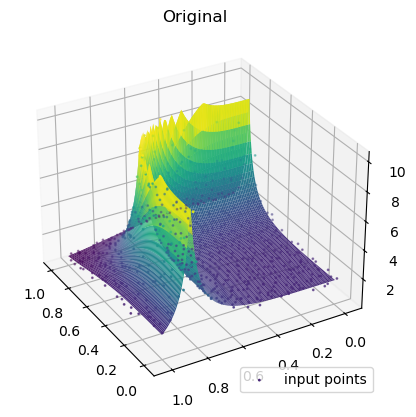

In [47]:
ax = plt.axes(projection="3d")
ax.plot_surface(
    grid_x,
    grid_y,
    function_6(grid_x, grid_y),
    rstride=1,
    cstride=1,
    cmap="viridis",
    edgecolor="none",
)
ax.scatter(rand_x, rand_y, values, c=values, cmap="viridis", label="input points", s=1)
ax.view_init(30, 150)
plt.title("Original")
plt.legend(loc="lower right")

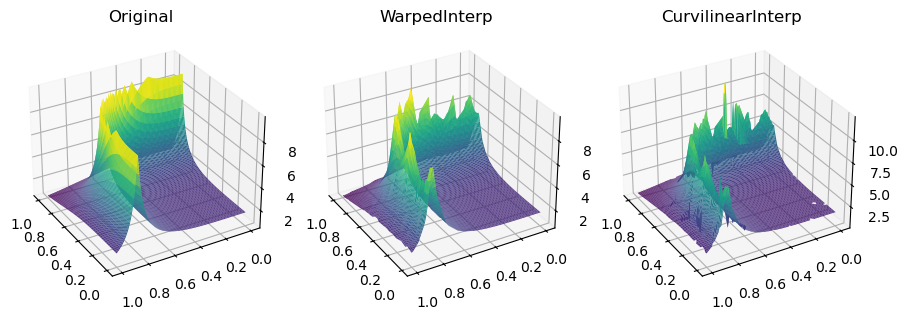

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), subplot_kw={"projection": "3d"})
titles = ["Original", "WarpedInterp", "CurvilinearInterp"]
grids = [function_6(grid_x, grid_y), warped_grid, curvilinear_grid]

for ax, title, grid in zip(axs.flat, titles, grids):
    im = ax.plot_surface(
        grid_x, grid_y, grid, rstride=1, cstride=1, cmap="viridis", edgecolor="none"
    )
    ax.set_title(title)
    ax.view_init(30, 150)

plt.tight_layout()
plt.show()